<a href="https://colab.research.google.com/github/MarinaChau/IASD_classes/blob/master/Criteo/Copie_de_Module5_TP_AdversarialAttacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

%load_ext google.colab.data_table
%tensorflow_version 2.x
import numpy as np
import pandas as pd
from google.colab import data_table
import os
import typing
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, \
  Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, \
  LeakyReLU, Dropout, Softmax, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from functools import partial
from tqdm import tqdm_notebook
from tensorflow.keras.datasets import fashion_mnist


In [2]:
%%capture
!pip install git+https://github.com/ThR3742/iasd-deep-learning-images

In [3]:
from dli.mlflow_helpers import log_metrics_and_params, tag_model

In [4]:
%%capture
!pip install adversarial-robustness-toolbox

In [5]:
%%capture
!pip install mlflow
import mlflow
import mlflow.tensorflow

In [6]:
from google.colab import drive
drive.mount('/content/drive')
cwd = "/content/drive/My Drive"
mlflow.set_tracking_uri(cwd + "/mlruns")
mlflow.set_experiment("adversarial_attacks")

def show_experiments():
  df = mlflow.search_runs(mlflow.get_experiment_by_name("adversarial_attacks").experiment_id)
  df.drop(columns=["experiment_id", "artifact_uri",
                   "tags.mlflow.log-model.history", "tags.mlflow.source.type",
                   "tags.model_summary", "tags.mlflow.source.name"], inplace=True)
  df.sort_values(by=["metrics.val_accuracy"], inplace=True, ascending=False)
  return data_table.DataTable(df, max_columns=30)

2022/03/29 08:32:08 INFO mlflow.tracking.fluent: Experiment with name 'adversarial_attacks' does not exist. Creating a new experiment.


Mounted at /content/drive


In [7]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


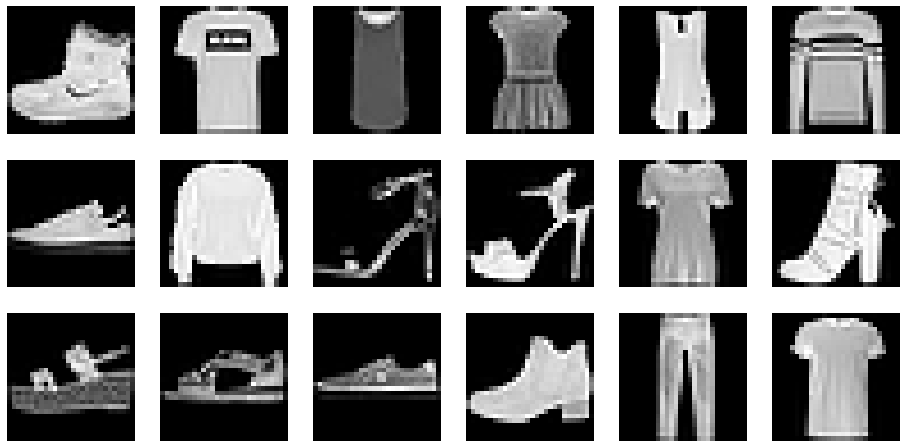

In [8]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

# I) Create model

In [9]:
# Define a configuration for your experiments
class ModelConfig(typing.NamedTuple):
  conv_layers: typing.List
  dense_layers: typing.List
  epochs: int = 1


In [11]:
# Exercise: create a simple classification model with good 
# accuracy on the dataset
def create_simple_model(config: ModelConfig):
    inp = Input(shape=(28, 28))

    np.random.seed(37)
    tf.random.set_seed(37)
    
    #### YOUR CODE HERE
    x = Reshape((28, 28, 1))(inp)

    for filters, kernel_size in config.conv_layers:
      x = Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation='relu')(x)
      x = MaxPool2D((2,2))(x)

    x = Flatten()(x)

    for nb_units, activation in config.dense_layers:
      x = Dense(units=nb_units, activation=activation)(x)
      
    x = Softmax()(x)
    
    model = Model(
        inputs=inp,
        outputs=x,
        name="lenet"
    )
    ####

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=1e-4),
        metrics=['accuracy']
    )
    return model

In [19]:
config = ModelConfig(
    conv_layers=[(10, 5), (20, 5), (30, 3)],
    dense_layers=[(50, "relu"), (10, None)]
)

model = create_simple_model(config)
model.summary()

Model: "lenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 20)          5020      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 20)         0         
 2D)                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
with mlflow.start_run(nested=True) as active_run:

  config = ModelConfig(
    conv_layers=[(10, 5), (20, 5)],
    dense_layers=[(50, "relu"), (10, None)],
    epochs=4
  )
  
  model = create_simple_model(config)

  history = model.fit(
      x=x_train,
      y=tf.one_hot(y_train, 10),
      validation_data=(x_test, tf.one_hot(y_test, 10)),
      epochs=config.epochs,
      batch_size=100
      )
  
  tag_model(model)
  mlflow.set_tag('training', "simple_training")

  log_metrics_and_params(history, config, active_run)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


600/600 [==============================] - 27s 45ms/step - loss: 2.1765 - accuracy: 0.5919 - val_loss: 0.9062 - val_accuracy: 0.7206
Epoch 2/4
600/600 [==============================] - 27s 45ms/step - loss: 0.7705 - accuracy: 0.7492 - val_loss: 0.7015 - val_accuracy: 0.7724
Epoch 3/4
 95/600 [===>..........................] - ETA: 21s - loss: 0.6552 - accuracy: 0.7716

In [14]:
show_experiments()

,run_id,status,start_time,end_time,metrics.val_loss,metrics.loss,metrics.val_accuracy,metrics.accuracy,params.optim_beta_2,params.epochs,params.optim_name,params.dense_layers,params.optim_decay,params.optim_epsilon,params.optim_amsgrad,params.optim_learning_rate,params.conv_layers,params.optim_beta_1,tags.mlflow.user,tags.training
0,cafb499d7382436c89708f994b26f732,FINISHED,2022-03-29 08:33:05.788000+00:00,2022-03-29 08:35:36.916000+00:00,0.552377,0.542073,0.8142,0.810367,0.999,4,Adam,"[(50, 'relu'), (10, None)]",0.0,1e-07,False,1e-04,"[(10, 5), (20, 5)]",0.9,root,simple_training


In [ ]:
class_to_name = {
    0:	"T-shirt/top",
    1:	"Trouser",
    2:	"Pullover",
    3:	"Dress",
    4:	"Coat",
    5:	"Sandal",
    6:	"Shirt",
    7:	"Sneaker",
    8:	"Bag",
    9:	"Ankle boot"
}

def show_dataset_and_predictions(x, y, model):

  plt.figure(figsize=(16, 8))
  for i in range(0, 18):
      plt.subplot(3, 6, i + 1)
      plt.imshow(x[i], cmap="gray")
      plt.text(0, 2, s=f"y_true={class_to_name[y[i]]}",
              bbox=dict(facecolor='blue', alpha=0.9),
              color="white")
      
      prediction = model.predict(np.expand_dims(x[i], 0))
      prediction = np.argmax(prediction)

      color = "green" if prediction == y[i] else "red"
      
      plt.text(0, 26, s=f"y_pred={class_to_name[prediction]}",
              bbox=dict(facecolor=color, alpha=0.9),
              color="white")

      plt.axis("off")
  plt.show()

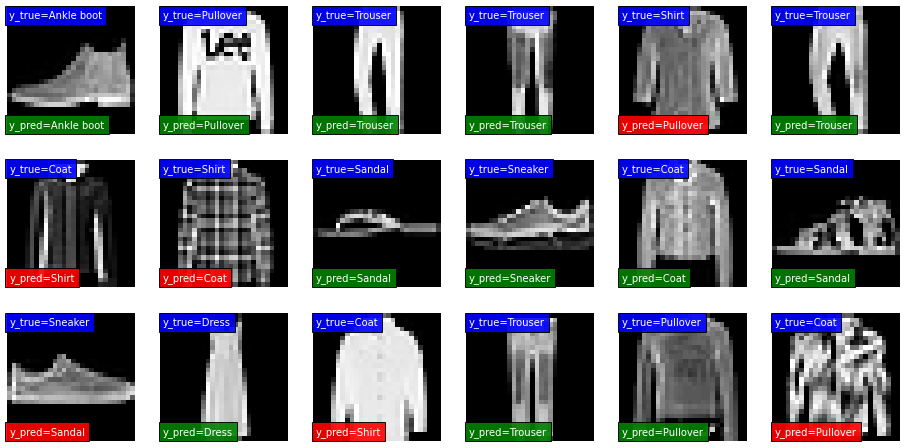

In [16]:
show_dataset_and_predictions(x_test, y_test, model)

# II) Implement adversarial attacks

## A) FGSM

In [ ]:
# Exercise: Display the top 20% of pixels  that can change the decision or a given model
# (Sensitivity Estimation)

def top_pixels(x_numpy, y_numpy, model=model):
  x = tf.constant(np.expand_dims(x_numpy, 0), dtype=tf.float32)
  y = tf.constant(tf.one_hot(y_numpy, 10))
  #### YOUR CODE HERE
  with tf.GradientTape() as g: 
    g.watch(x)
    
    p = model(x)
    loss = tf.keras.backend.categorical_crossentropy(target=y, output=tf.reshape(p, -1))
    dloss_dx = g.gradient(loss, x)
    impact = np.abs(dloss_dx)
    
  q = np.quantile(impact, 0.90)
  impact[impact<q] = 0
  impact[impact>=q] = 1
  ####

  plt.imshow(x_numpy, cmap="gray")
  plt.imshow(np.squeeze(impact, 0), cmap="RdBu_r", alpha=0.8)


plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    top_pixels(x_test[i], y_test[i])
    plt.axis("off")
plt.show()

In [ ]:
# Exercise: Implement the simple FGSM attack seen in class

def fgsm(x_numpy, y_numpy, epsilon, model=model):
  x = tf.constant(np.expand_dims(x_numpy, 0), dtype=tf.float32)
  y = tf.constant(tf.one_hot(y_numpy, 10))
  with tf.GradientTape() as g: 
    g.watch(x)
    #### YOUR CODE HERE
    p = model(x)
    loss = tf.keras.backend.categorical_crossentropy(target=y, output=tf.reshape(p, -1))
    dloss_dx = g.gradient(loss, x)
    gradient = np.sign(dloss_dx)
    x_attack = x + epsilon * gradient
    x_attack = np.reshape(x_attack, (28, 28))
    x_attack = np.clip(np.floor(x_attack), 0, 255)
    ####
  return x_attack
    

x_fgsm = [fgsm(x_test[idx], y_test[idx], 10) for idx in tqdm_notebook(range(18))]  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/18 [00:00<?, ?it/s]

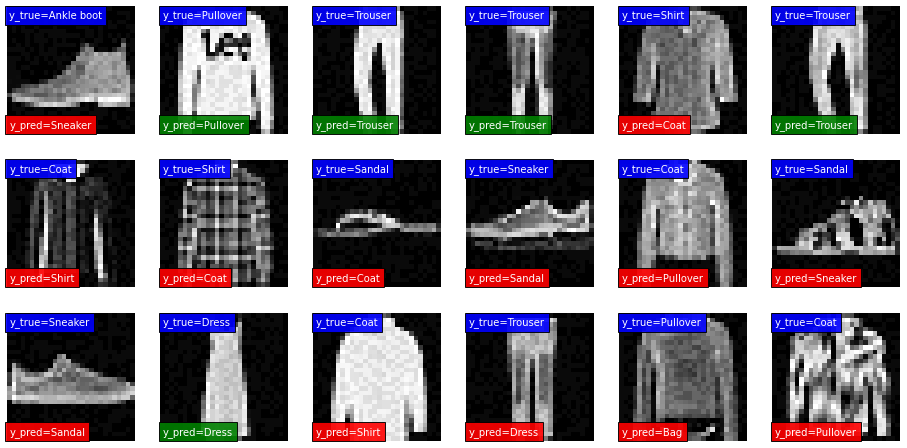

In [ ]:
show_dataset_and_predictions(x_fgsm, y_test, model)

## B) BIM

In [ ]:
# Exercise: Implement the BIM attack seen in class

def bim(x_numpy, y_numpy, epsilon, num_iter, model=model):

  epsilon_iter = 10 * epsilon / num_iter

  x = tf.constant(np.expand_dims(x_numpy, 0), dtype=tf.float32)
  x_attack = x
  y = tf.constant(tf.one_hot(y_numpy, 10))

  #### YOUR CODE HERE
  for _ in range(num_iter):
    with tf.GradientTape() as g: 
      g.watch(x_attack)
      p = model(x_attack)
      loss = tf.keras.backend.categorical_crossentropy(target=y, output=tf.reshape(p, -1))
      dloss_dx = g.gradient(loss, x_attack)
      gradient = np.sign(dloss_dx)
      x_attack = x_attack + epsilon_iter*gradient
      eta = tf.clip_by_value(x_attack - x, -epsilon, epsilon)
      x_attack = tf.clip_by_value(x+eta, 0, 255)
  ####

  return np.reshape(np.floor(x_attack), (28, 28))

x_bim = [bim(x_test[idx], y_test[idx], 10, 200) for idx in tqdm_notebook(range(18))]  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/18 [00:00<?, ?it/s]

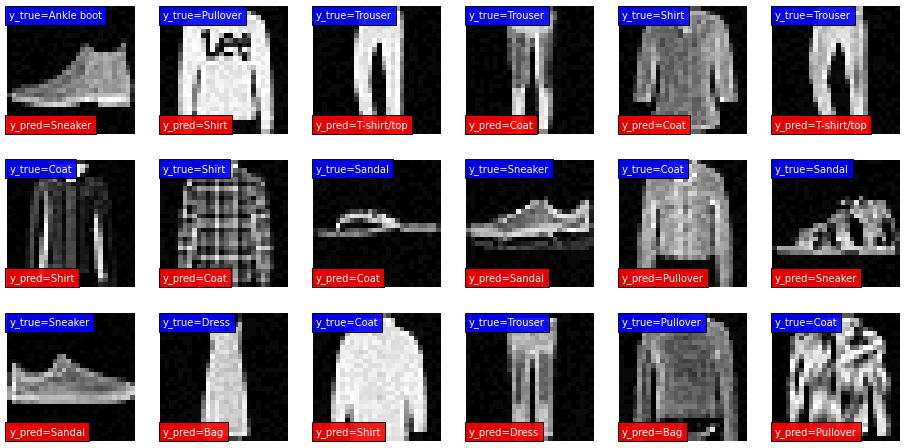

In [ ]:
show_dataset_and_predictions(x_bim, y_test, model)

## C) Experiment with art

In [ ]:
from art.attacks.evasion import CarliniLInfMethod
from art.estimators.classification import TensorFlowV2Classifier
classifier = TensorFlowV2Classifier(model, nb_classes=10, input_shape=(28, 28))

In [ ]:
# Exercice: Check the documentation of the art library from IBM
# (https://adversarial-robustness-toolbox.readthedocs.io/en/latest/index.html)
# Try to run at least the CW attack we saw during the class and check the different parameters

attacker = CarliniLInfMethod(classifier)
x_deepfool = [np.squeeze(attacker.generate(np.expand_dims(x_test[idx], 0).astype(np.float32)), axis=0) for idx in tqdm_notebook(range(18))]  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/18 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

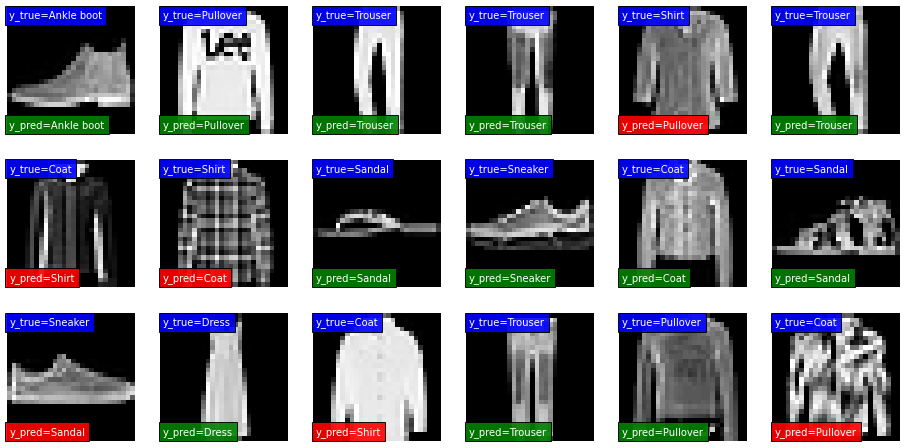

In [ ]:
show_dataset_and_predictions(x_deepfool, y_test, model)

## D) Accuracies and adversarial accuracies

In [ ]:
# Exercice: write a function to compute the adversarial accuracy of a model

def evaluate_adversarial_accuracy(attack_func=None, num_points=1000, model=model):
  if attack_func is None:
    x_evaluation = x_test[:num_points]
  else:
    attack_func = partial(attack_func, model=model)
    x_evaluation = np.array([attack_func(x_test[idx], y_test[idx]) for idx in tqdm_notebook(range(num_points))])
  
  y_evaluation = y_test[:num_points]

  return model.evaluate(x_evaluation, tf.one_hot(y_evaluation, 10))[1]

In [ ]:
# Exercice: write a function to compute the adversarial accuracy of all the models
# you have in your mlflow db

from mlflow.tracking import MlflowClient
from mlflow.entities import Metric

client = MlflowClient()

from mlflow.keras import load_model
for run_info in client.list_run_infos(mlflow.get_experiment_by_name("adversarial_attacks").experiment_id):
    model_dir = run_info.artifact_uri + "/model"
    if not os.path.exists(model_dir):
      continue
    model = load_model(model_dir)
    
    all_metrics = list()
    for eps in [1, 10, 50]:
      adv_accuracy = evaluate_adversarial_accuracy(
          attack_func=partial(fgsm, epsilon=eps), num_points=1000, model=model)

      metric = Metric(
                  key=f"adv_acc_fgsm_{eps}",
                  value=adv_accuracy,
                  timestamp=0,
                  step=0,
        )
      all_metrics.append(metric)
    client.log_batch(run_id=run_info.run_id, metrics=all_metrics)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1000 [00:00<?, ?it/s]

32/32 [==============================] - 0s 7ms/step - loss: 0.9888 - accuracy: 0.6660


  0%|          | 0/1000 [00:00<?, ?it/s]

32/32 [==============================] - 0s 7ms/step - loss: 4.1224 - accuracy: 0.1790


  0%|          | 0/1000 [00:00<?, ?it/s]

32/32 [==============================] - 0s 7ms/step - loss: 6.0585 - accuracy: 0.0850


  0%|          | 0/1000 [00:00<?, ?it/s]

32/32 [==============================] - 0s 6ms/step - loss: 0.7497 - accuracy: 0.7480


  0%|          | 0/1000 [00:00<?, ?it/s]

32/32 [==============================] - 0s 6ms/step - loss: 3.5176 - accuracy: 0.2210


  0%|          | 0/1000 [00:00<?, ?it/s]

32/32 [==============================] - 0s 6ms/step - loss: 5.8855 - accuracy: 0.0800


In [ ]:
show_experiments()

,run_id,status,start_time,end_time,metrics.accuracy,metrics.adv_acc_fgsm_50,metrics.val_accuracy,metrics.adv_acc_fgsm_1,metrics.val_loss,metrics.loss,...,params.optim_amsgrad,params.optim_decay,params.optim_beta_1,params.optim_name,params.optim_learning_rate,params.optim_beta_2,params.optim_epsilon,params.dense_layers,tags.mlflow.user,tags.training
1,7b81c41c31ec43ed8885bd5e9395d88b,FINISHED,2022-03-28 14:09:07.546000+00:00,2022-03-28 14:14:39.737000+00:00,0.871233,0.080,0.8538,0.748,0.421951,0.359535,...,False,0.0,0.9,Adam,1e-04,0.999,1e-07,"[(50, 'relu'), (10, None)]",root,simple_training
0,48f6ea3793a34a40a4b8cc68535243fe,FINISHED,2022-03-29 06:27:53.188000+00:00,2022-03-29 06:29:39.086000+00:00,0.810367,0.085,0.8142,0.666,0.552377,0.542073,...,False,0.0,0.9,Adam,1e-04,0.999,1e-07,"[(50, 'relu'), (10, None)]",root,simple_training


# III) Data Augmentation

In [ ]:
# Exercise:
# * Try to use data augmentation with FGSM and see if it improves the adversarial accuracy 
# * Check the accuracy of the new model, what do you observe ?

#### YOUR CODE
num_points_augmentation=10000
x_augment = np.array([fgsm(x_train[idx], y_train[idx], 1, model) for idx in tqdm_notebook(range(num_points_augmentation))])
x_train_augmented = np.concatenate([x_train, x_augment], axis=0)
y_train_augmented = np.concatenate([y_train, np.array([y_train[idx] for idx in range(num_points_augmentation)])], axis=0)
####

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
with mlflow.start_run(nested=True) as active_run:

  config = ModelConfig(
    conv_layers=[(10, 5), (20, 5)],
    dense_layers=[(50, "relu"), (10, None)],
    epochs=4
  )
  
  model = create_simple_model(config)

  history = model.fit(
      x=x_train_augmented,
      y=tf.one_hot(y_train_augmented, 10),
      validation_data=(x_test, tf.one_hot(y_test, 10)),
      epochs=config.epochs,
      batch_size=100
      )
  
  mlflow.keras.log_model(model, artifact_path='model')
  mlflow.set_tag('training', "adv_training")

  log_metrics_and_params(history, config, active_run)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


700/700 [==============================] - 33s 45ms/step - loss: 2.0397 - accuracy: 0.6039 - val_loss: 0.8557 - val_accuracy: 0.7354
Epoch 2/4
700/700 [==============================] - 28s 40ms/step - loss: 0.7490 - accuracy: 0.7514 - val_loss: 0.6691 - val_accuracy: 0.7789
Epoch 3/4
700/700 [==============================] - 28s 40ms/step - loss: 0.6098 - accuracy: 0.7886 - val_loss: 0.5874 - val_accuracy: 0.8024
Epoch 4/4
700/700 [==============================] - 28s 40ms/step - loss: 0.5363 - accuracy: 0.8103 - val_loss: 0.5404 - val_accuracy: 0.8162


2022/03/29 06:44:04 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.2+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


# IV) Attack Transferability

In [ ]:
# Exercise: Train two models with different architectures and see how we can transfer attacks from one to another